## Introduction and Motivation 

This project consists of a transactional database for a bank in India. The objective is to segment the different customer groups based on transactional activity and customer demographics. Because understanding your customers is paramount to improving customer acquisition and retention, conducting a customer segmentation analysis can provide opportunities to deliver more personalized services to the bank's customer base. The customer and transaction dataset can be obtained from the source below. If the dataset no longer exists, please reach out to me at nathanling9730@gmail.com and I will send it to you accordingly.

Dataset Source: https://www.kaggle.com/shivamb/bank-customer-segmentation

## Table of Contents

<a href='#1.0'><b><h2>1.0 Load Data<b></a><br>
<a href='#2.0'><b><h2>2.0 EDA<b></a><br>
<a href='#3.0'><b><h2>3.0 Imputing Null Values<b></a><br>
<a href='#4.0'><b><h2>4.0 Feature Engineering<b></a><br>
<a href='#4.1'><b><h3>4.1 Hour of Day<b></a><br>
<a href='#4.2'><b><h3>4.2 Customer Age<b></a><br>
<a href='#4.3'><b><h3>4.3 City Size<b></a><br>
<a href='#4.4'><b><h3>4.4 Regions of India<b></a><br>
<a href='#4.5'><b><h3>4.5 Number of Transactions<b></a><br>
<a href='#5.0'><b><h2>5.0 Data Consolidation<b></a><br>
<a href='#6.0'><b><h2>6.0 Data Sampling<b></a><br>
<a href='#7.0'><b><h2>7.0 Outlier Removal and Feature Scaling<b></a><br>
<a href='#8.0'><b><h2>8.0 Algorithm Hyperparameter Tuning<b></a><br>
<a href='#9.0'><b><h2>9.0 Final Model<b></a><br>
<a href='#10.0'><b><h2>10.0 Post Hoc Analyses<b></a><br>
<a href='#10.1'><b><h3>10.1 Key Insights<b></a><br>
<a href='#10.2'><b><h3>10.2 Cluster Groups<b></a><br>
<a href='#10.3'><b><h3>10.3 Cluster Specific Marketing Strategies<b></a><br>
<a href='#10.4'><b><h3>10.4 Customer Acquisition Strategies<b></a><br>

<a id='1.0'></a>
## 1.0 Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

**Important Note:** If the dataset from kaggle is not named "bank_transactions.csv", please rename it to whatever the current name is.

In [2]:
transactions_df = pd.read_csv('bank_transactions.csv')

In [3]:
transactions_df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


There are 1048567 transactions in total

In [4]:
transactions_df.shape

(1048567, 9)

In [6]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Given that although there's null values, the percentage of nulls is very low. Hence, mean/median/mode imputation can be done for the features with null values.

In [7]:
((transactions_df.isnull().sum() / transactions_df.shape[0])*100).apply(lambda x: str(round(x, 2)) + '%')

TransactionID               0.0%
CustomerID                  0.0%
CustomerDOB                0.32%
CustGender                  0.1%
CustLocation               0.01%
CustAccountBalance         0.23%
TransactionDate             0.0%
TransactionTime             0.0%
TransactionAmount (INR)     0.0%
dtype: object

<a id='2.0'></a>
## 2.0 EDA

This section explores the dataset so that we can clean it up as well as generate new features that could enrich the customer segementation analysis.

There are 884265 unique customers. Given that the number of transactions is greater than the number of unique customers, some customers may have made more than 1 purchase in the timeframe of this dataset.

In [8]:
transactions_df['CustomerID'].nunique()

884265

There are 9355 distinct customer locations. We may need to bucket customer locations into regions for analysis.

In [9]:
transactions_df['CustLocation'].nunique()

9355

Identifying top 10 cities with most customers.

**Insights:** The cities with most customers are in the major cities and the country capital, with that being major financial centers such as Mumbai and Gurgaon.

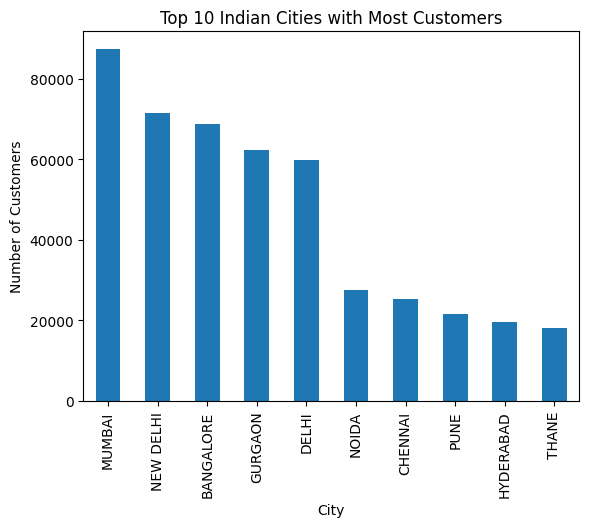

In [10]:
transactions_df.drop_duplicates(subset=['CustomerID'])['CustLocation'].value_counts()[:10].plot(kind='bar');
plt.title('Top 10 Indian Cities with Most Customers');
plt.ylabel('Number of Customers');
plt.xlabel('City');

This table has transactions spanning from August 1 to October 21, 2016, a 2.5 month period.

In [11]:
transactions_df['TransactionDate'].unique()

array(['2/8/16', '1/8/16', '3/8/16', '5/8/16', '4/8/16', '6/8/16',
       '9/8/16', '8/8/16', '12/8/16', '7/8/16', '21/10/16', '16/10/16',
       '10/8/16', '14/8/16', '17/8/16', '21/8/16', '19/8/16', '24/8/16',
       '22/8/16', '29/8/16', '31/8/16', '22/9/16', '23/9/16', '13/8/16',
       '25/8/16', '28/8/16', '15/8/16', '27/8/16', '20/8/16', '23/8/16',
       '30/8/16', '11/8/16', '16/8/16', '26/8/16', '27/9/16', '18/8/16',
       '25/9/16', '26/9/16', '30/9/16', '3/9/16', '2/9/16', '1/9/16',
       '6/9/16', '5/9/16', '4/9/16', '9/9/16', '8/9/16', '7/9/16',
       '12/9/16', '11/9/16', '10/9/16', '15/9/16', '14/9/16', '13/9/16',
       '18/9/16'], dtype=object)

The transaction time most likely represents the time of day given that the maximum likely means 23:59:59, or 11:59:59pm. Given this information, we can create a feature that represents the time of day the transaction was made.

In [12]:
transactions_df['TransactionTime'].agg({'min', 'max'})

max    235959
min         0
Name: TransactionTime, dtype: int64

Given that the format for the customer date of birth is "dd/mm/yy", we can extract the year of birth by getting the numbers after the last '/'.

In [13]:
transactions_df['CustomerDOB'].head()

0     10/1/94
1      4/4/57
2    26/11/96
3     14/9/73
4     24/3/88
Name: CustomerDOB, dtype: object

Visualizing the gender distribution of the customer base.

The majority of customers are male.

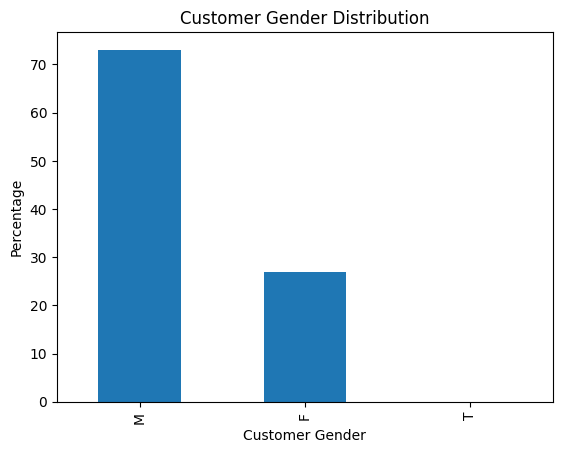

In [14]:
((transactions_df.drop_duplicates(subset=['CustomerID'])['CustGender'].value_counts(normalize=True))*100).plot(kind='bar');
plt.title('Customer Gender Distribution');
plt.ylabel('Percentage');
plt.xlabel('Customer Gender');

Displaying the customer account balance distribution and the maximum customer account balance. 

**Insights:** We see that the majority of customers have a bank balance of less than 25000 (INR). We also see that there are severe outliers in the dataset given the discrepency between the maximum and the values seen in the plot.

In [15]:
transactions_df['CustAccountBalance'].max()

np.float64(115035495.1)

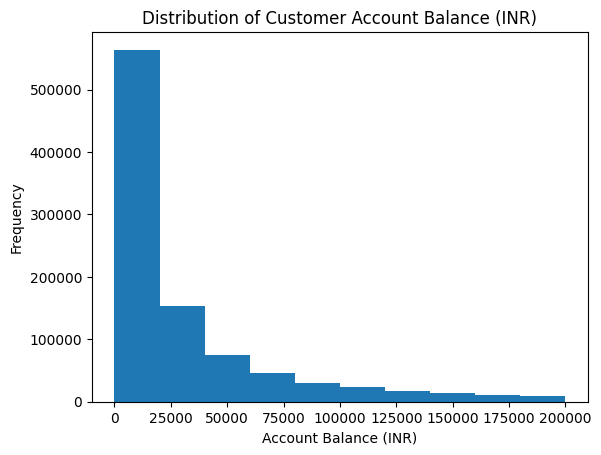

In [16]:
transactions_df['CustAccountBalance'][transactions_df['CustAccountBalance'] < 200000].plot(kind='hist');
plt.title('Distribution of Customer Account Balance (INR)');
plt.xlabel('Account Balance (INR)');

Displaying the transaction amount distribution and maximum transaction amount. 

**Insights:** We see that the majority of customers transact less than 1000 (INR). We also see that there are severe outliers in the dataset given the discrepency between the maximum and the values seen in the plot

In [17]:
transactions_df['TransactionAmount (INR)'].max()

np.float64(1560034.99)

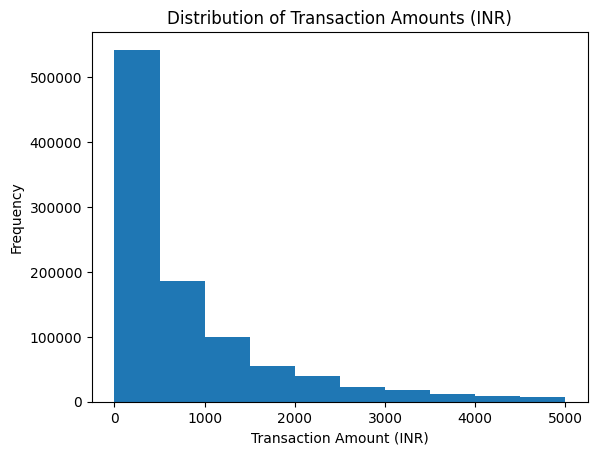

In [18]:
transactions_df['TransactionAmount (INR)'][transactions_df['TransactionAmount (INR)'] < 5000].plot(kind='hist');
plt.title('Distribution of Transaction Amounts (INR)');
plt.xlabel('Transaction Amount (INR)');

<a id='3.0'></a>
## 3.0 Imputing null values

Given the outliers in the numerical data, median rather than mean imputation would be more suitable. As for the categorical features, mode imputation will be most appropriate.

In [19]:
most_common_gender = transactions_df['CustGender'].mode().values[0]
transactions_df['CustGender'] = transactions_df['CustGender'].fillna(most_common_gender)

In [20]:
avg_cust_acct_balance = transactions_df['CustAccountBalance'].median()
transactions_df['CustAccountBalance'] = transactions_df['CustAccountBalance'].fillna(avg_cust_acct_balance)

In [21]:
most_common_location = transactions_df['CustLocation'].mode().values[0]
transactions_df['CustLocation'] = transactions_df['CustLocation'].fillna(most_common_location)

<a id='4.0'></a>
## 4.0 Feature Engineering

### 4.1 Hour of Day

Because India follows one time zone, we do not need to be concerned with time zone variations.

**Insights:** Most customers make transactions in the evening hours.

In [22]:
transactions_df['Hour'] = transactions_df['TransactionTime'] // 10000

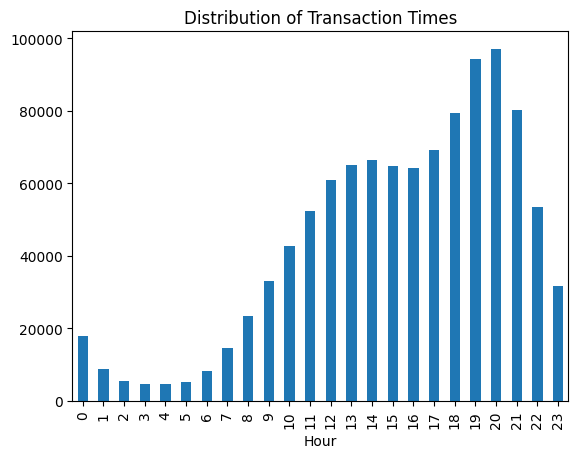

In [23]:
transactions_df['Hour'].value_counts().reindex(range(0, 24)).plot(kind='bar');
plt.title('Distribution of Transaction Times');
plt.xlabel('Hour');

### 4.2 Customer Age

To obtain the customer's age, we first extract their year of birth.

In [24]:
transactions_df['Customer_YOB'] = \
transactions_df['CustomerDOB'].apply(lambda x: int(x.split('/')[-1]) if pd.notna(x) else np.nan)

Displaying the year of birth. We see that it spans from 0 to 99, with the exception of 1800 and nulls. The years from 0-99 either represent a date in the 20th or 21st century.

**Insights:** The year of birth is almost continuous with the exception of '17. We can safely assume that because this dataset covers transactions in 2016, any date lower or equal to '16 comprises of bank accounts for people born in the 21th century and 20th century for everyone else. It is more likely that parents are opening bank accounts for their kids rather than the situation of senior citizens over 100 years old having bank accounts. This is because the percentage of Indian centenarians are nearly 0. It is even more unlikely that a centenarian happened to be a customer of this bank in particular who made a transaction between August and October of 2016. The gap in '17 could be that there is no one who was born in 1917 who has a bank account and made a transaction. <br>
Source: https://en.wikipedia.org/wiki/Demographics_of_India

In [25]:
print(sorted(transactions_df['Customer_YOB'].unique()))

[np.float64(0.0), np.float64(4.0), np.float64(21.0), np.float64(32.0), np.float64(41.0), np.float64(43.0), np.float64(47.0), np.float64(51.0), np.float64(53.0), np.float64(54.0), np.float64(56.0), np.float64(57.0), np.float64(59.0), np.float64(60.0), np.float64(65.0), np.float64(66.0), np.float64(67.0), np.float64(68.0), np.float64(69.0), np.float64(70.0), np.float64(71.0), np.float64(72.0), np.float64(73.0), np.float64(74.0), np.float64(75.0), np.float64(76.0), np.float64(77.0), np.float64(78.0), np.float64(79.0), np.float64(80.0), np.float64(81.0), np.float64(82.0), np.float64(83.0), np.float64(84.0), np.float64(85.0), np.float64(86.0), np.float64(87.0), np.float64(88.0), np.float64(89.0), np.float64(90.0), np.float64(91.0), np.float64(92.0), np.float64(93.0), np.float64(94.0), np.float64(95.0), np.float64(96.0), np.float64(97.0), np.float64(98.0), np.float64(99.0), np.float64(1800.0), np.float64(nan), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(5.0), np.float64(6.0

Based on the DOB, 1/1/1800 is usually a placeholder for null values. Given this finding, we can safely assume 1800 YOB can be transformed to nulls.

In [26]:
transactions_df[transactions_df['Customer_YOB'] == 1800].head(2)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Hour,Customer_YOB
16,T17,C1376215,1/1/1800,M,MUMBAI,77495.15,1/8/16,124727,1423.11,12,1800.0
22,T23,C7018081,1/1/1800,M,WAYS PANCHKUVA AHMEDABAD,143.07,3/8/16,104718,110.00,10,1800.0


Converting any 1800 values to nulls

In [27]:
transactions_df['Customer_YOB'] = transactions_df['Customer_YOB'].replace(1800, np.nan)

Visualizing the distribution of the years of birth. 

**Insights:** We see that there are some outliers as the majority of transactions are from people who are born in the '80s to '99. Hence, median imputation will be the most optimal for the year of birth rather than mean.

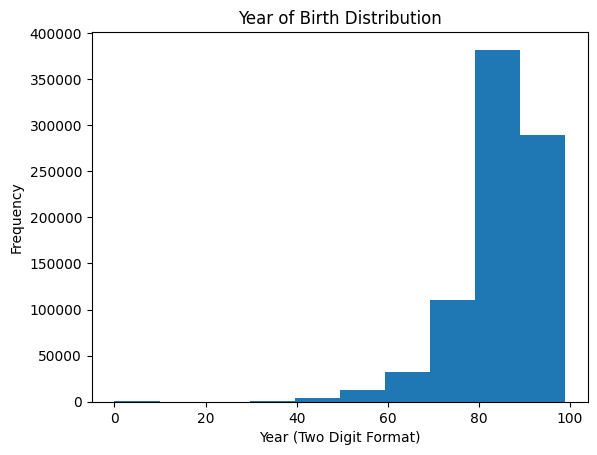

In [28]:
transactions_df.drop_duplicates(subset=['CustomerID'])['Customer_YOB'].plot(kind='hist');
plt.title('Year of Birth Distribution');
plt.xlabel('Year (Two Digit Format)');

Imputing the average year of birth

In [29]:
avg_year = transactions_df['Customer_YOB'].median()
print(avg_year)
transactions_df['Customer_YOB'] = transactions_df['Customer_YOB'].fillna(avg_year)
transactions_df['Customer_YOB'] = transactions_df['Customer_YOB'].astype(int)

87.0


Calculating the calendar year in order to obtain the customer's age

In [30]:
def calendar_yr(x):
    if x <= 16:
        return 2000 + x
    elif x <= 100:
        return 1900 + x
    else:
        return x

In [31]:
transactions_df['Customer_YOB'] = transactions_df['Customer_YOB'].apply(calendar_yr)
transactions_df['Customer_YOB'].unique()

array([1994, 1957, 1996, 1973, 1988, 1972, 1992, 1982, 1984, 1978, 1968,
       1987, 1989, 1991, 1985, 1993, 1986, 1967, 1979, 1977, 1997, 1983,
       1990, 1980, 1981, 1966, 1975, 1995, 1974, 1971, 1932, 1959, 1999,
       1965, 1941, 1954, 1970, 1976, 1921, 1969, 2004, 1943, 1998, 1951,
       1960, 1956, 1953, 1947, 2000, 1964, 1948, 1962, 1952, 1955, 1961,
       1936, 1963, 1942, 1944, 1938, 2002, 1949, 1958, 1950, 1946, 1945,
       1937, 2007, 2001, 1939, 1940, 2013, 2003, 2005, 2010, 2011, 1933,
       1934, 1927, 1919, 1928, 1930, 2009, 1931, 1929, 1935, 2015, 2016,
       2006, 2008, 2012, 1923, 1926, 1924, 1922, 2014, 1920, 1925, 1918])

Getting the calendar year of the transaction. Based on analyzing the dates in this dataset, we know that there are only transactions in 2016 in this dataset.

In [32]:
transactions_df['year'] = transactions_df['TransactionDate'].apply(lambda x: int(str(x).split('/')[-1]) + 2000)

Calculating the customer age and sanity checking to ensure it makes sense. The median age of a bank customer being 29 years old makes sense, given that the median age in India is roughly 28.4 years old.

Source: https://www.worldometers.info/world-population/india-population/

In [33]:
transactions_df['Customer_age'] = transactions_df['year'] - transactions_df['Customer_YOB']
transactions_df.drop_duplicates(subset=['CustomerID'])['Customer_age'].median()

np.float64(29.0)

Visualizing the distribution of customer age.

**Insights:** The majority of customers are of a relatively young age, being between 20 to 40 years of age.

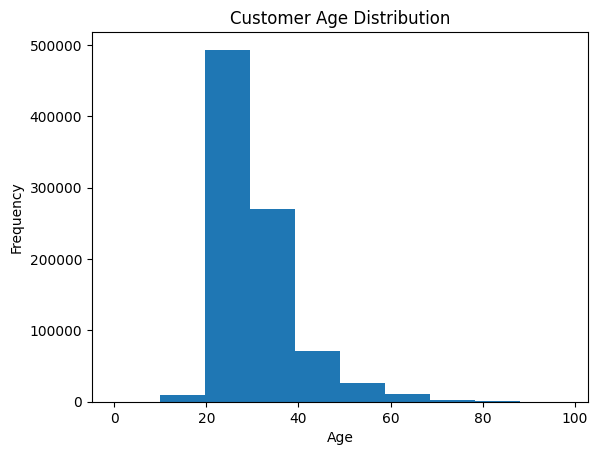

In [34]:
transactions_df.drop_duplicates(subset=['CustomerID'])['Customer_age'].plot(kind='hist');
plt.title('Customer Age Distribution');
plt.xlabel('Age');

### 4.3 City Size

Bucketing the customer locations by size (either large or small). The definition of a large city for this analysis will be customer locations with over 1 million people.

Source: https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population

Loading the cities that have populations of over 1 million people.

In [35]:
city_population_df = pd.read_csv('Indian Cities by Population.csv', header=None).rename(columns={0: 'City', 1: 'Population'})
city_population_df.head()

,City,Population
0,Mumbai,"12,442,373"
1,Delhi,"11,007,835"
2,Bangalore,"8,425,970"
3,Hyderabad,"6,809,970"
4,Ahmedabad,"5,570,585"


In [36]:
city_population_df['City'] = city_population_df['City'].apply(lambda x: x.lower())

In [37]:
transactions_df['CustLocation'] = transactions_df['CustLocation'].apply(lambda x: x.lower())

Joining the population data with the transactions table

In [38]:
transactions_df = \
transactions_df.merge(city_population_df, left_on='CustLocation', right_on='City', how='left')\
.drop(columns=['City'])

In [39]:
transactions_df['Population'] = transactions_df['Population'].str.replace(',', '')
transactions_df['Population'].fillna(0, inplace=True)
transactions_df['Population'] = transactions_df['Population'].astype(int)

/tmp/ipykernel_3363/3400468328.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions_df['Population'].fillna(0, inplace=True)


Bucketing the customer locations into large or small cities

In [40]:
transactions_df['Population'] = transactions_df['Population'].apply(lambda x: 'Large City' if x >= 1000000 else 'Small City')

In [41]:
transactions_df = transactions_df.rename(columns={'Population': 'City Size'})

Visualizing the distribution of customers from large vs small cities.

**Insights:** Majority of customers come from large cities.

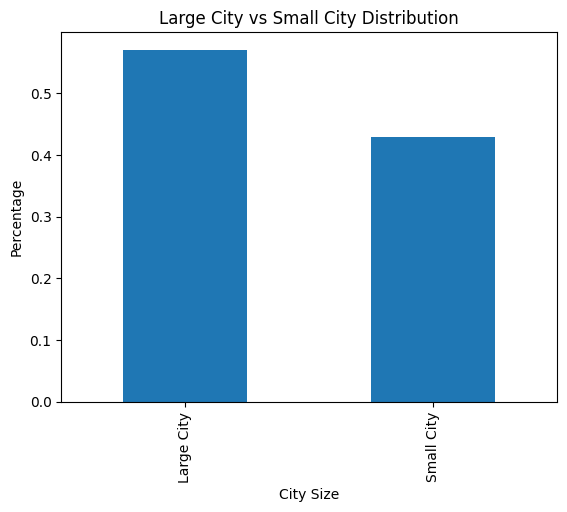

In [42]:
transactions_df.drop_duplicates(subset=['CustomerID'])['City Size'].value_counts(normalize=True).plot(kind='bar');
plt.title('Large City vs Small City Distribution');
plt.xlabel('City Size');
plt.ylabel('Percentage');

### 4.4 Regions of India

Creating a new feature that buckets the cities into the different regions in India.

Source: https://www.krisia.com/city_list.htm

In [43]:
regions_df = pd.read_csv('Indian Cities and Regions.csv')

In [44]:
regions_df['City'] = regions_df['City'].apply(lambda x: x.lower())

In [45]:
transactions_df = transactions_df.merge(regions_df, left_on='CustLocation', right_on='City', how='left')

In [46]:
transactions_df.drop(columns=['City', 'State'], inplace=True)

Analyzing the distribution of transactions from each region.

**Insights:** The majority of transactions are from North India.

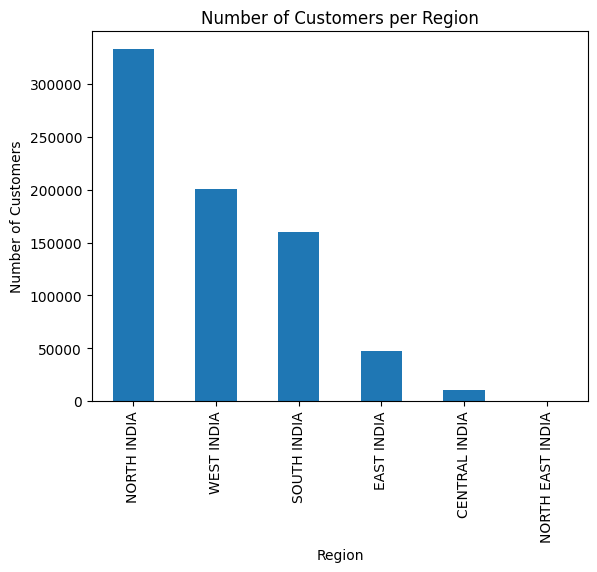

In [47]:
transactions_df.drop_duplicates(subset=['CustomerID'])['Region'].value_counts().plot(kind='bar');
plt.title('Number of Customers per Region');
plt.ylabel('Number of Customers');
plt.xlabel('Region');

### 4.5 Number of Transactions

Displaying the frequency count for different number of transactions made by customers within the 2.5 month period. The majority of customers have only made 1 transaction within the 2.5 month window. This can be a new feature to be created once we bucket the data into the customer level. 

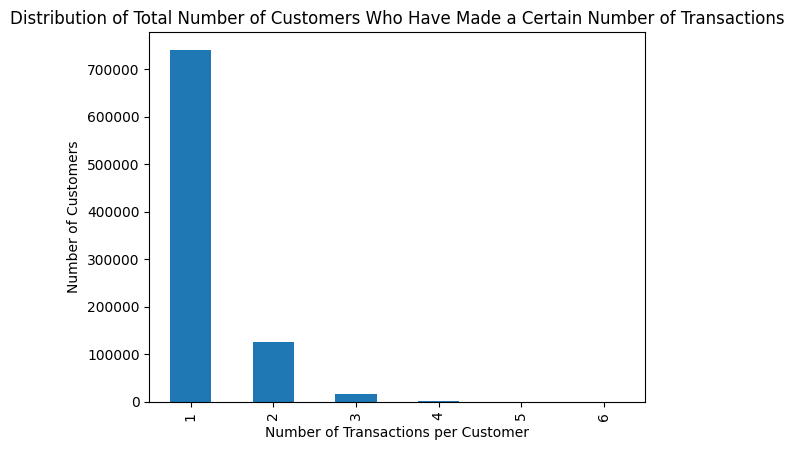

In [48]:
transactions_df.groupby('CustomerID')['TransactionID'].count().value_counts().plot(kind='bar');
plt.title('Distribution of Total Number of Customers Who Have Made a Certain Number of Transactions');
plt.ylabel('Number of Customers');
plt.xlabel('Number of Transactions per Customer');

<a id='5.0'></a>
## 5.0 Data Consolidation

Consolidating the data set from transaction level to customer level. Because the goal is to segment customers, we want to analyze the data for each individual customer as the event, rather than the transaction.

In [49]:
numeric_customers_df = transactions_df.groupby('CustomerID', as_index=False).agg({'TransactionID': 'count',
                                           'CustAccountBalance': 'mean',
                                           'TransactionAmount (INR)': 'mean',
                                           'Customer_age': 'mean',
                                           'Hour': 'mean'})\
.rename(columns={'TransactionID': 'Number of Transactions',
                'TransactionAmount (INR)': 'Average Transacted (INR)'})

In [50]:
numeric_customers_df.head(2)

,CustomerID,Number of Transactions,CustAccountBalance,Average Transacted (INR),Customer_age,Hour
0,C1010011,2,76340.635,2553.0,28.5,6.5
1,C1010012,1,24204.490,1499.0,22.0,20.0


In [51]:
numeric_customers_df.shape

(884265, 6)

Getting the non-numerical data. Given that the number of rows is the same as the aggregated numerical data, we can join the two tables together

In [52]:
non_numeric_customers_df = transactions_df.drop_duplicates(subset=['CustomerID'], keep='first')\
[['CustomerID', 'CustGender', 'CustLocation', 'City Size', 'Region']]
non_numeric_customers_df.head(2)

,CustomerID,CustGender,CustLocation,City Size,Region
0,C5841053,F,jamshedpur,Small City,EAST INDIA
1,C2142763,M,jhajjar,Small City,NORTH INDIA


In [53]:
non_numeric_customers_df.shape

(884265, 5)

Joining the two tables together to get a mix of numerical and categorical data for the customer segmentation model and analysis.

In [54]:
customers_df = numeric_customers_df.merge(non_numeric_customers_df, on='CustomerID')
customers_df.head(2)

,CustomerID,Number of Transactions,CustAccountBalance,Average Transacted (INR),Customer_age,Hour,CustGender,CustLocation,City Size,Region
0,C1010011,2,76340.635,2553.0,28.5,6.5,F,noida,Small City,NORTH INDIA
1,C1010012,1,24204.490,1499.0,22.0,20.0,M,mumbai,Large City,WEST INDIA


<a id='6.0'></a>
## 6.0 Data Sampling

As silhouette analysis takes a very long time to run for large datasets, we are generating samples of the data to speed up the analysis. 100000 samples were chosen specifically as this number is large enough to be representative of the general customer population but small enough that the silhouette analysis will not take ages to run.

In [55]:
customers_df_sample = customers_df.sample(n=100000, random_state=37)

<a id='7.0'></a>
## 7.0 Outlier Removal and Feature Scaling

Given the abundance of outliers in the dataset, it is important to remove outliers so that we don't end up with small clusters that exist only containing the outlier values.

In [56]:
# Setting up the parameters
numeric_columns = ['Number of Transactions', 'CustAccountBalance', 'Average Transacted (INR)', 'Customer_age', 'Hour']
capped_col_name = [col + ' Capped' for col in numeric_columns]
lower_quantile = [0.25]*len(numeric_columns)
upper_quantile = [0.85] + [0.75]*4 # 0.85 is used for Number of Transactions column because the 0.75 quantile 
# was found to return 1, the exact same as 0.25, which would mean that a static number of 1 will be returned for 
# this feature after capping, which provides no meaningful analysis

for i in range(len(numeric_columns)):
    lower, upper = customers_df_sample[numeric_columns[i]].quantile([lower_quantile[i], upper_quantile[i]])
    iqr = upper - lower
    top_boundary = upper + (iqr*1.5)
    bottom_boundary = lower - (iqr*1.5)
    customers_df_sample[capped_col_name[i]] = customers_df_sample[numeric_columns[i]]
    customers_df_sample.loc[customers_df_sample[capped_col_name[i]] >= top_boundary, capped_col_name[i]] = top_boundary
    customers_df_sample.loc[customers_df_sample[capped_col_name[i]] <= bottom_boundary, capped_col_name[i]] = bottom_boundary

/tmp/ipykernel_3363/2179570219.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customers_df_sample.loc[customers_df_sample[capped_col_name[i]] >= top_boundary, capped_col_name[i]] = top_boundary


In [57]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = RobustScaler() # It was found that robust scaler produces better silhouette scores than standard scaler
# scaler = StandardScaler()

Scaling the data so that the euclidean distance calculating in the K-means algorithm is magnitude neutral.

In [59]:
scaled_col_name = [col + ' Scaled' for col in numeric_columns]
for i in range(len(numeric_columns)):
    customers_df_sample[scaled_col_name[i]] = scaler.fit_transform(customers_df_sample[[capped_col_name[i]]])

<a id='8.0'></a>
## 8.0 Algorithm Hyperparameter Tuning

In [60]:
customer_data_kmeans = customers_df_sample[scaled_col_name]

In [74]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
# from scikitplot.cluster import plot_elbow_curve
# from scikitplot.metrics import plot_silhouette

Plotting the elbow curve. 

**Insights:** Appears that 3-4 clusters is the inflection point. However, the elbow plot only analyzes the entire dataset as a whole and does not provide insights on the quality of the clusters themselves. Thus, more analysis is required to determine the optimal number of clusters.

Text(0, 0.5, 'Sum of Squared Errors')

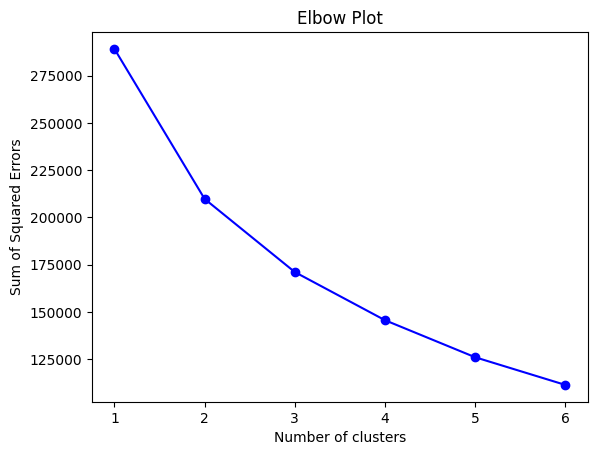

In [63]:
sse = [] 
for i in range(1, 7): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(customer_data_kmeans) 
    sse.append(kmeans.inertia_)

plt.plot(range(1,7), sse, 'bo-')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')

Analyzing cluster performance for different cluster sizes using a silhouette plot

**Important Note:** Silhouette analysis takes a long time to calculate. This could take between 20-30 minutes to run.

**Insights:** Based on both the elbow plot and silhouette scores, 3 clusters would be the optimal number. The reason is because the silhouette score starts to decrease rapidly after 3 clusters. Furthermore, having more clusters may result in information overload for the marketing team with regards to understanding the patterns and characteristics of each cluster. Although 2 clusters has the highest overall silhouette score, it is not much higher than 3. Furthermore, segmenting customers into only 2 clusters would be too general and is not enough to properly capture the different demographic and behavioral patterns of the bank's customers. This argument is supported by the relatively high sum of squared errors for 2 clusters. Finally, for the 2 clusters, although the silhouette score is the best, only the majority class (labelled as 1) is clustered properly as nearly the entire segment for the minority class (labelled as 0) has a silhouette score below the mean. For these reasons, 3 clusters would be the most optimal.

Distribution of clusters for 2 clusters are
0    67277
1    32723
Name: count, dtype: int64
For n_clusters = 2 The average silhouette_score is: 0.3235505201455244
Distribution of clusters for 3 clusters are
1    62779
2    20079
0    17142
Name: count, dtype: int64
For n_clusters = 3 The average silhouette_score is: 0.3191984091764012
Distribution of clusters for 4 clusters are
1    50384
0    18736
3    16552
2    14328
Name: count, dtype: int64
For n_clusters = 4 The average silhouette_score is: 0.27659769969710307
Distribution of clusters for 5 clusters are
1    32595
2    21942
0    18336
4    13580
3    13547
Name: count, dtype: int64
For n_clusters = 5 The average silhouette_score is: 0.25062749504934234


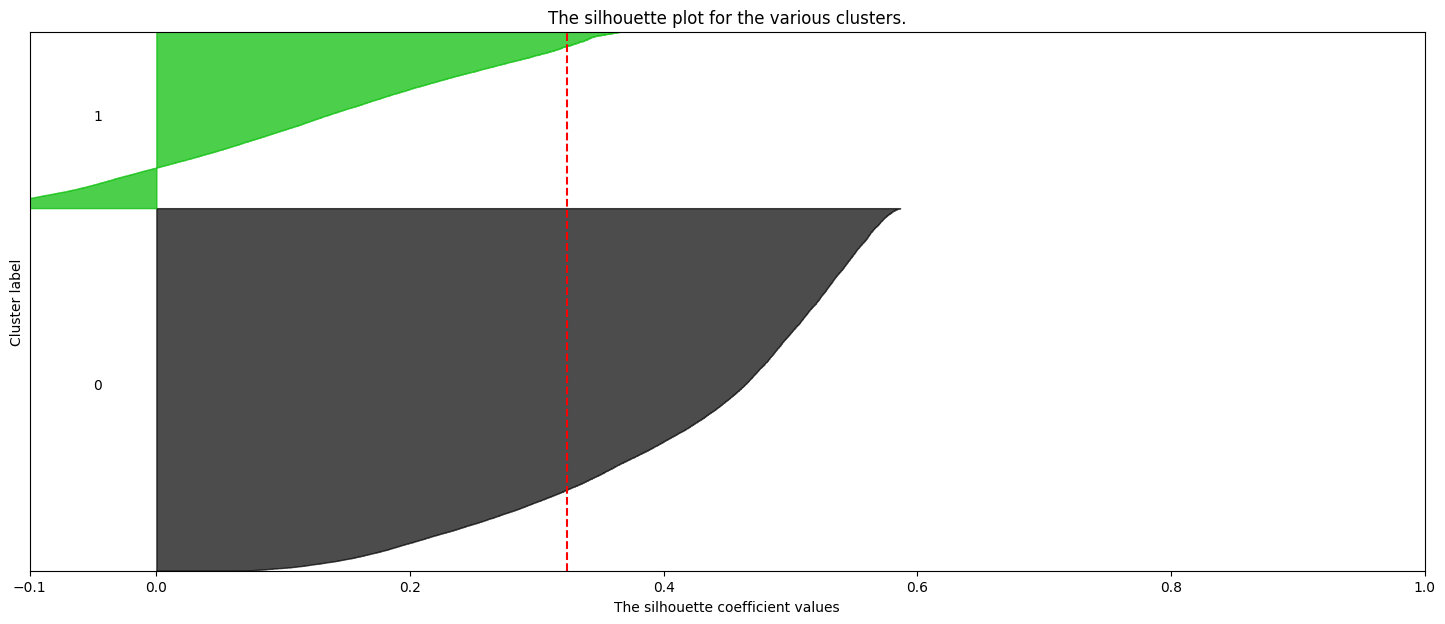

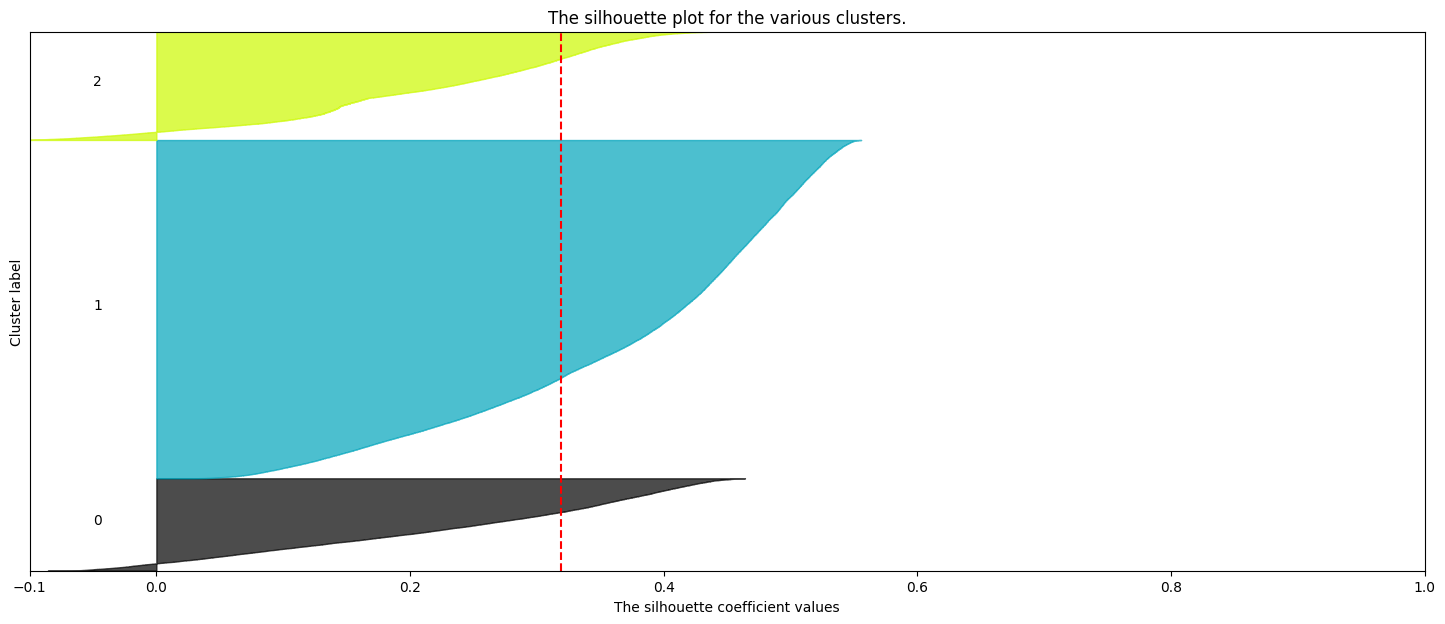

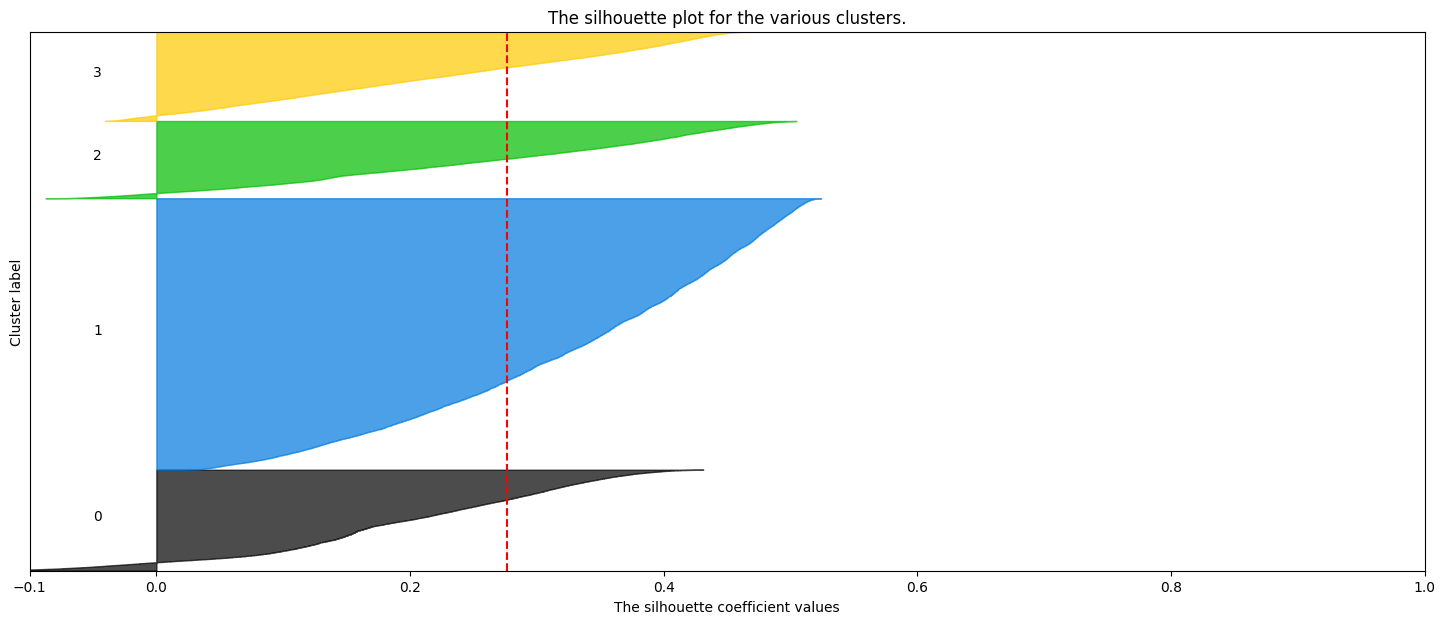

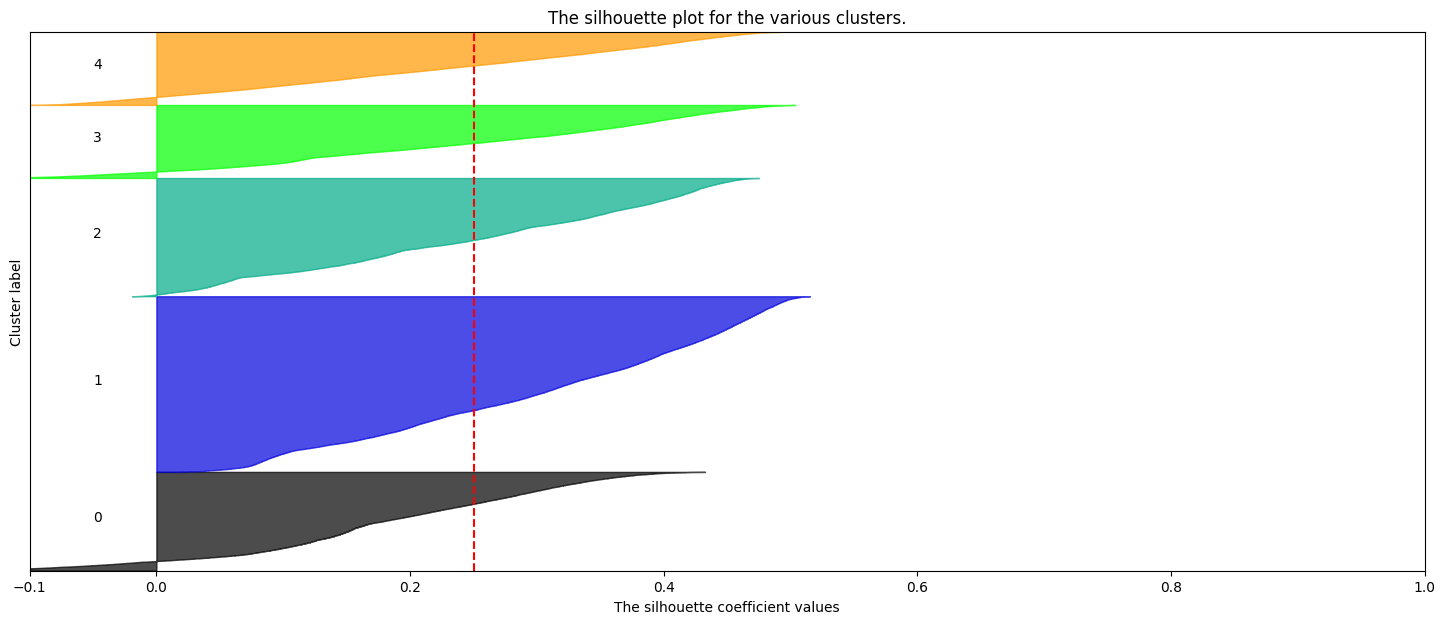

In [87]:
for n_clusters in range(2, 6):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(customer_data_kmeans) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=20, random_state=31)
    cluster_labels = clusterer.fit_predict(customer_data_kmeans)
    print(f'Distribution of clusters for {n_clusters} clusters are')
    print(pd.Series(cluster_labels).value_counts())

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(customer_data_kmeans, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is:",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(customer_data_kmeans, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

<a id='9.0'></a>
## 9.0 Final Model

From above analysis, it is determined 3 clusters is optimal. Thus, we will generate labels for 3 clusters.

In [88]:
model = KMeans(3, n_init=20, random_state=31)

In [89]:
model_labels = model.fit_predict(customer_data_kmeans)

In [90]:
customers_df_sample['cluster'] = model_labels

Visualizing the distribution of each cluster.

**Insights** The majority of customers belong to cluster 0

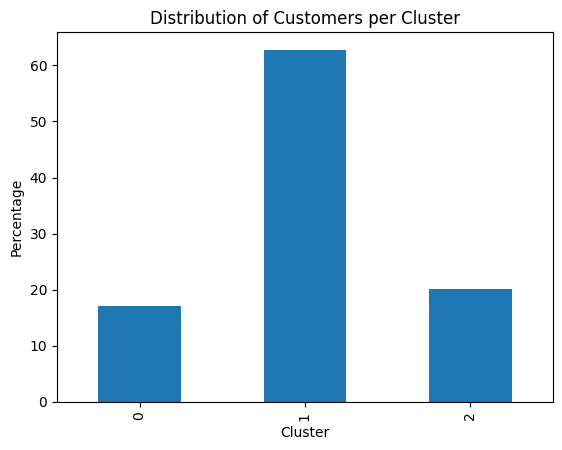

In [91]:
(100*customers_df_sample['cluster']
 .value_counts(normalize=True)
 .reindex([0, 1, 2])).plot(kind='bar');
plt.title('Distribution of Customers per Cluster');
plt.xlabel('Cluster');
plt.ylabel('Percentage');

<a id='10.0'></a>
## 10.0 Post Hoc Analyses

Calculating summary statistics for each numerical feature for each cluster

In [92]:
customers_df_continuous_stats = customers_df_sample.groupby('cluster').agg({'CustAccountBalance': 'mean',
                                            'Average Transacted (INR)': 'mean',
                                           'Customer_age': 'mean',
                                           'Number of Transactions': 'mean',
                                           'Hour': 'mean'})\
.rename(columns={'CustAccountBalance': 'Average Customer Account Balance',
                'Customer_age': 'Average Customer Age',
                'Number of Transactions': 'Average Number of Transactions',
                'Hour': 'Average Transaction Time of Day (Hour)'})\
.apply(lambda x: round(x, 2), axis=1)
customers_df_continuous_stats

,Average Customer Account Balance,Average Transacted (INR),Average Customer Age,Average Number of Transactions,Average Transaction Time of Day (Hour)
cluster,,,,,
0,28493.13,4718.33,33.71,1.20,15.85
1,17746.08,385.67,28.86,1.16,15.28
2,513066.80,2677.20,35.00,1.24,15.41


Visualizing the summary statistics for each cluster

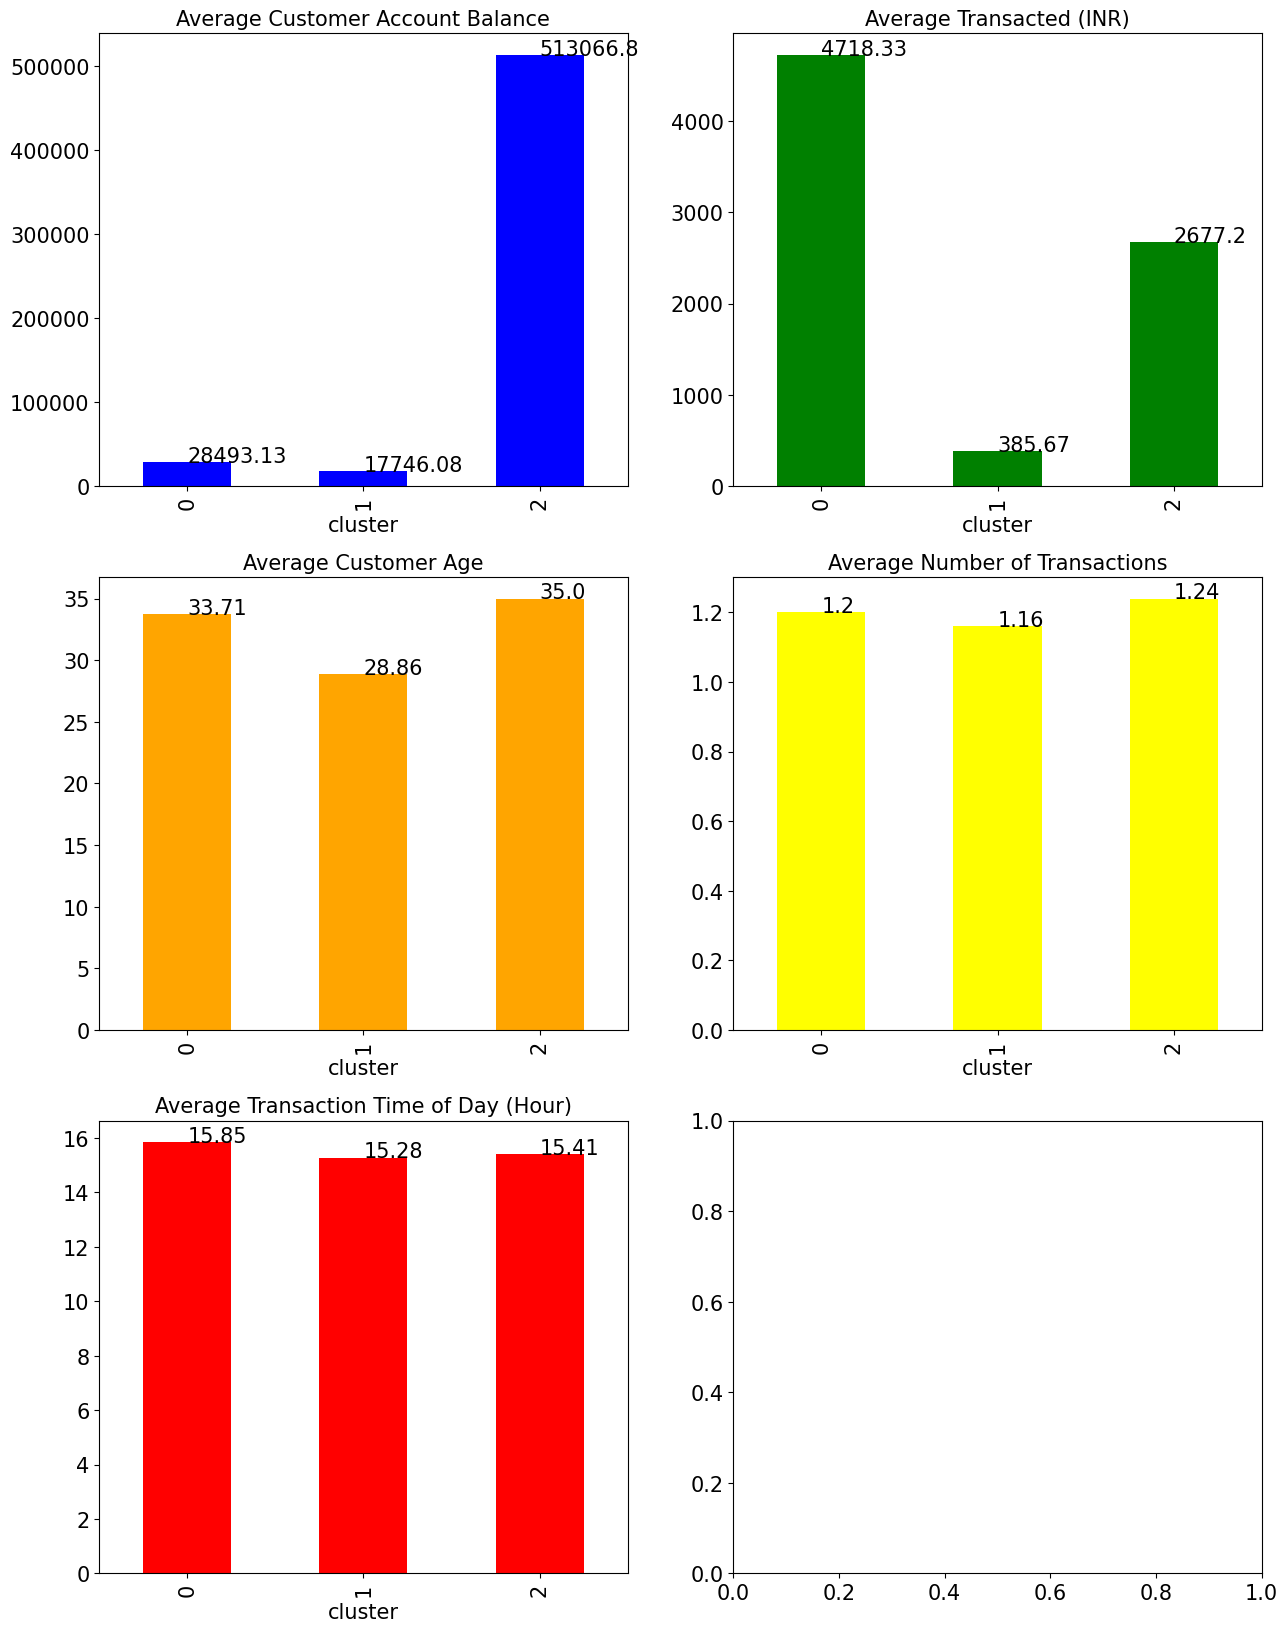

In [94]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
x = [0, 1, 2] # Cluster labels
colors = ['blue', 'green', 'orange', 'yellow', 'red'] # Setting different colours for each graph
for index, column in enumerate(customers_df_continuous_stats.columns):
    row = index // 2
    col = index % 2
    customers_df_continuous_stats[column].plot(kind='bar', ax=axes[row,col], color=colors[index])
    axes[row,col].set_title(column)
    y = customers_df_continuous_stats[column].values
    for a,b in zip(x,y):
        axes[row,col].annotate(str(b), xy=(a,b))

Calculating the proportions of each cluster for each category

In [95]:
categorical_cols = ['CustGender', 'City Size', 'Region', 'CustLocation']
for col in categorical_cols:
    if customers_df_sample[col].nunique() < 10:
        print(customers_df_sample.groupby(col)['cluster']\
              .value_counts(normalize=True).unstack())
        print('')
    else:
        # Get the cluster distribution for the top 5 most frequent values in the feature
        customers_df_sample_top_5 = \
        customers_df_sample[customers_df_sample[col].isin(customers_df_sample[col].value_counts()[:5].index)]
        print(customers_df_sample_top_5.groupby(col)['cluster']\
              .value_counts(normalize=True).unstack())
        print('')

cluster            0         1         2
CustGender                              
F           0.194144  0.590610  0.215246
M           0.163111  0.641384  0.195504

cluster            0         1         2
City Size                               
Large City  0.175787  0.611509  0.212705
Small City  0.165627  0.649388  0.184984

cluster                  0         1         2
Region                                        
CENTRAL INDIA     0.200000  0.625000  0.175000
EAST INDIA        0.189098  0.622177  0.188725
NORTH EAST INDIA  0.338983  0.491525  0.169492
NORTH INDIA       0.166344  0.605738  0.227918
SOUTH INDIA       0.167949  0.660061  0.171990
WEST INDIA        0.182423  0.606622  0.210955

cluster              0         1         2
CustLocation                              
bangalore     0.166237  0.640444  0.193320
delhi         0.156401  0.631163  0.212436
gurgaon       0.158293  0.596203  0.245504
mumbai        0.192460  0.558073  0.249467
new delhi     0.180693  0.540855  0

Visualizing the proportions of each cluster for each category

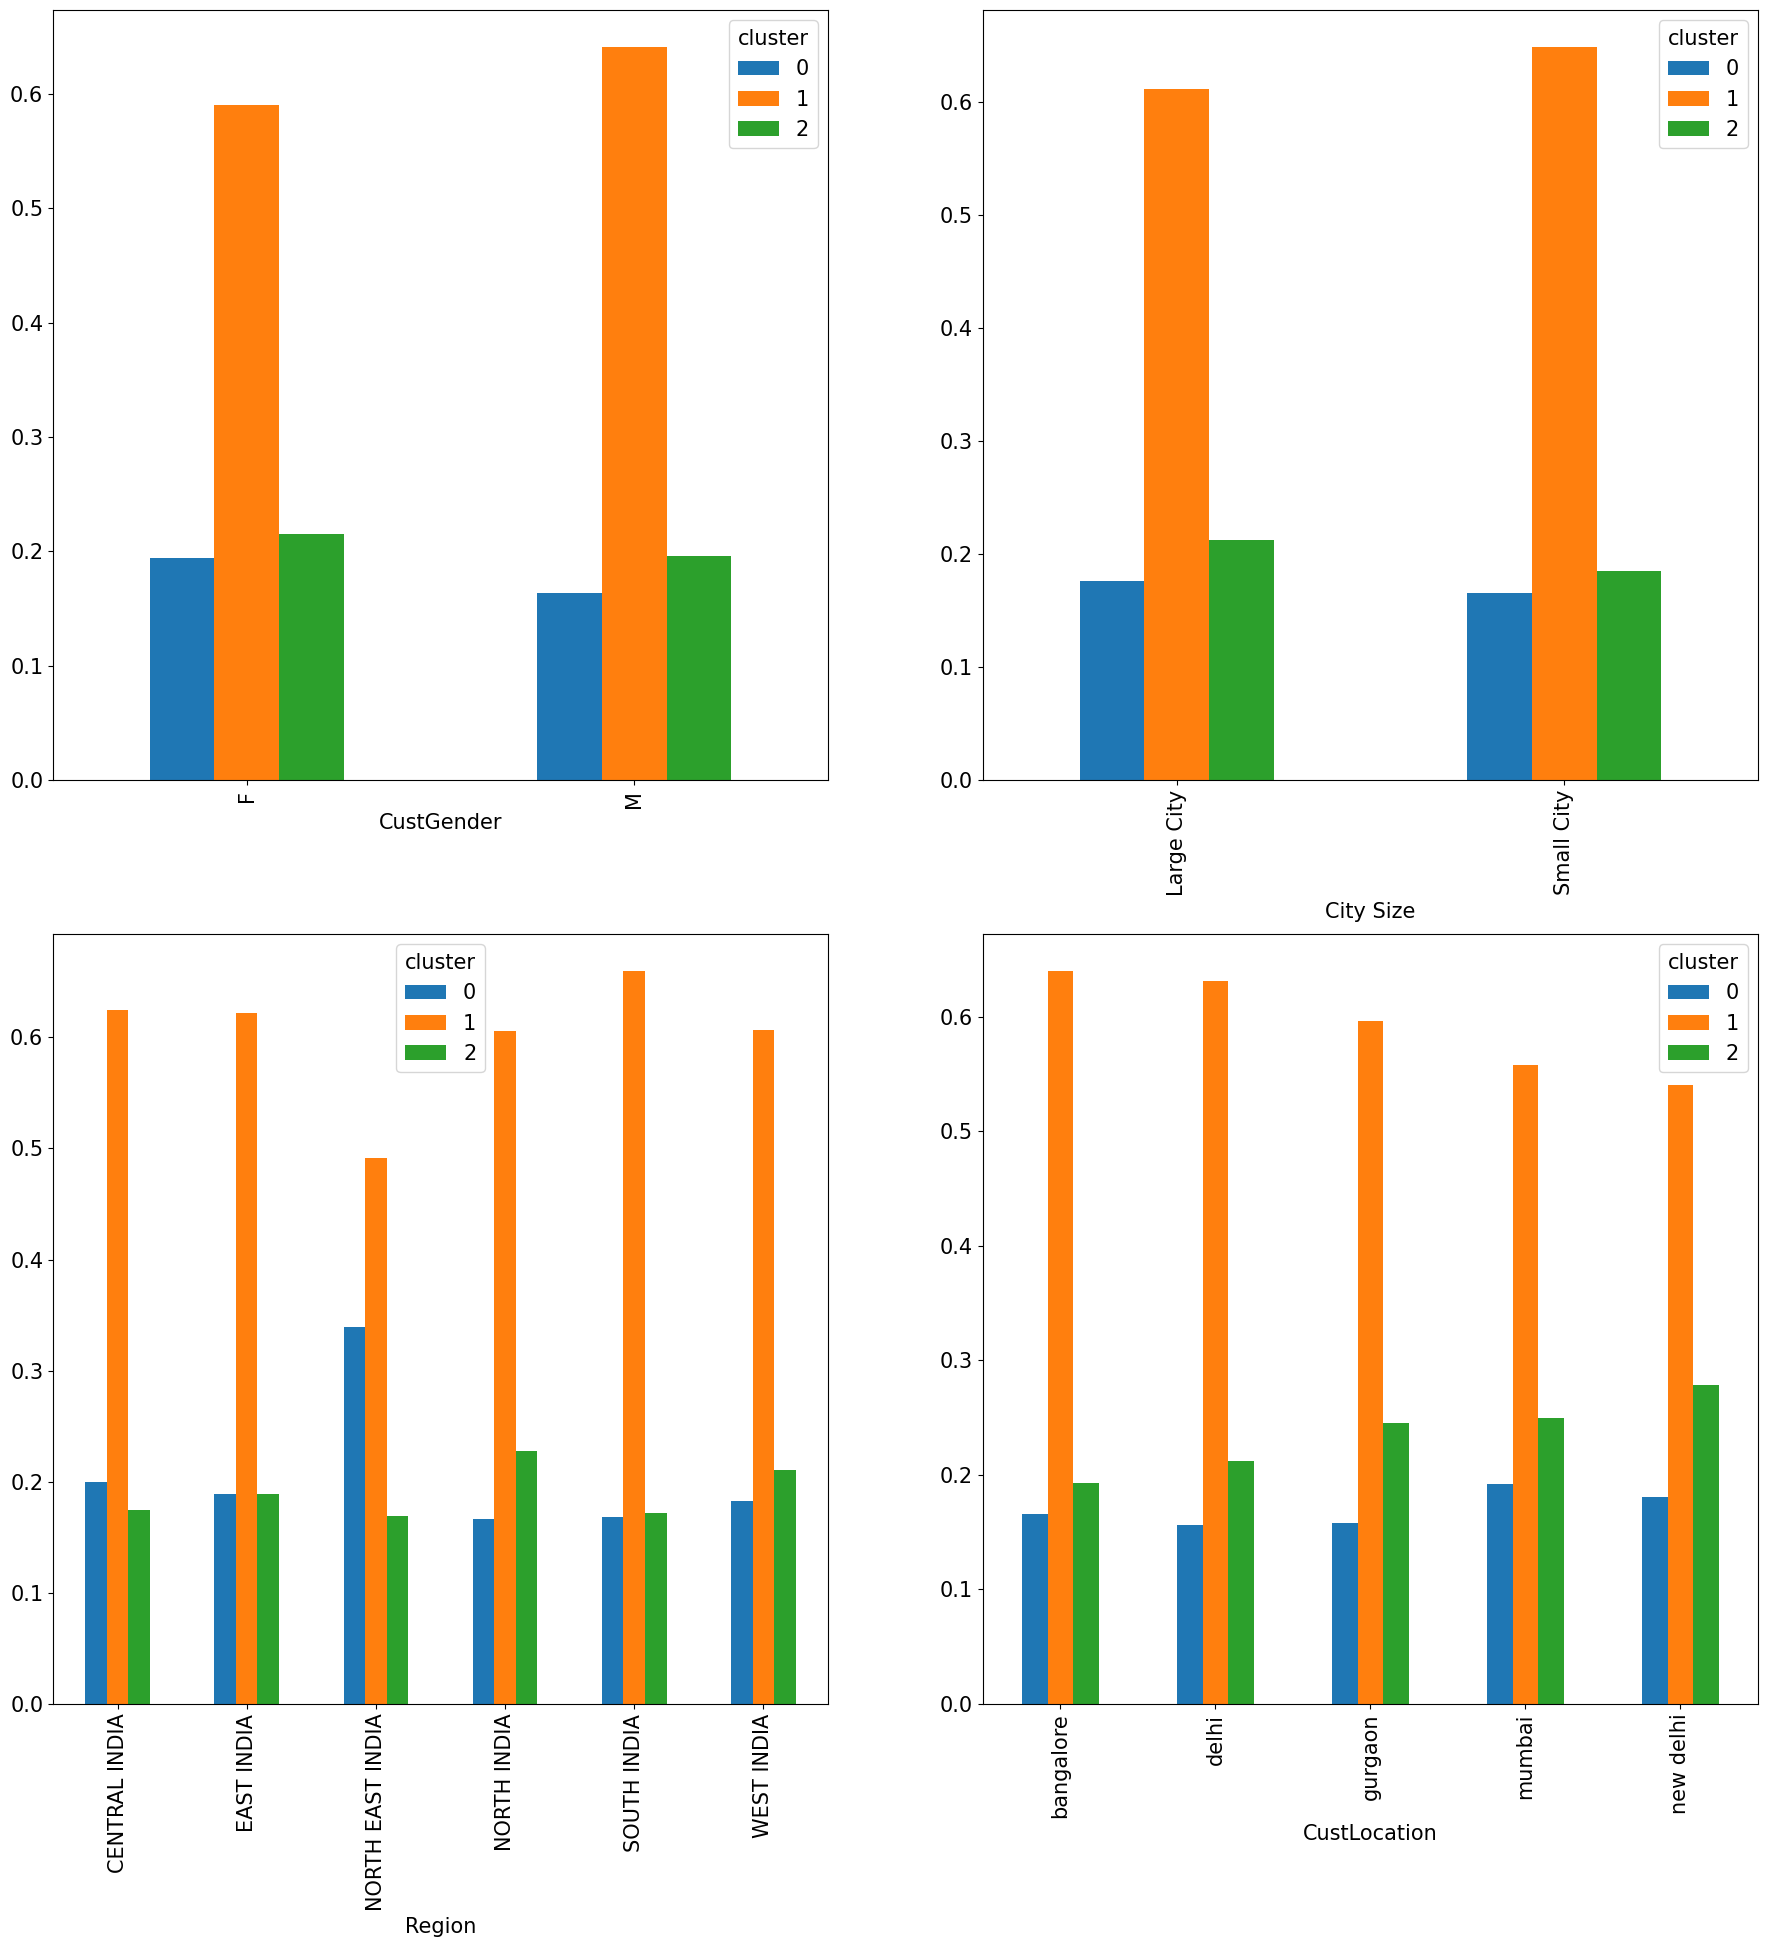

In [96]:
categorical_cols = ['CustGender', 'City Size', 'Region', 'CustLocation']
fig, axes = plt.subplots(2, 2, figsize=(22, 22))
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
for index, column in enumerate(categorical_cols):
    row = index // 2
    col = index % 2
    if customers_df_sample[column].nunique() < 10:
        customers_df_sample.groupby(column)['cluster']\
              .value_counts(normalize=True).unstack().plot(kind='bar', ax=axes[row, col]);
    else:
        # Get the cluster distribution for the top 5 most frequent values in the feature
        customers_df_sample_top_5 = \
        customers_df_sample[customers_df_sample[column].isin(customers_df_sample[column].value_counts()[:5].index)]
        customers_df_sample_top_5.groupby(column)['cluster']\
              .value_counts(normalize=True).unstack().plot(kind='bar', ax=axes[row, col]);

<a id='10.1'></a>
### 10.1 Key Insights

1. There are enormous account balance disparities in the customer base, with cluster 2 having a much higher average account balance than the others. This suggests that cluster 2 has a strong ability to save money by saving more than they spend.<br>
2. Customers with the largest account balances do not spend the most. It is cluster 0 that has the largest average transaction amounts. This could indicate high income and high spender, but inability to save money.<br>
3. As cluster 1 has the least in savings and spends the least, it is likely that this group also has lower incomes. Because over 60% of the customer base belongs to cluster 1, this suggests that India still likely has a large issue with income disparity and that the majority of bank customers in the country are not very well off.<br>
4. Cluster 1 also has the lowest average age, at 28.9 compared to 33.7 and 35 for cluster 0 and 2 respectively. This pattern may be because building wealth takes time, with incomes and savings growing as you get older.<br>
5. The differences in the average number of transactions and the average time of day a transaction is made between the clusters are negligible. <br>
6. North and West India have the largest proportion of cluster 2 customers. Northeast India has the largest proportion of cluster 0 customers. On the other hand, South India has the largest proportion of cluster 1 customers.<br>
7. New Delhi and Mumbai, the country capital and the largest financial hub respectively, have a relatively low proportion of cluster 1 customers in comparison with the other cities, suggesting customers are more well off in these cities.<br>
8. There is an inverse relationship between wealth and the city size the customer lives in. Large cities have a slightly larger proportion of bank customers that belong to cluster 2 while the smaller cities have a slightly larger segment of customers in customer 1. This is indicative of the urban rural divide.<br>
9. Female clientele have a slightly larger proportion of bank customers that belong to the cluster 0 and 2 while male clientele have a slightly larger segment of customers in cluster 1.

<a id='10.2'></a>
### 10.2 Cluster Groups

Source: https://www.greenwich.com/commercial-banking/advanced-segmentation-focuses-customer-behavior-needs-and-characteristics

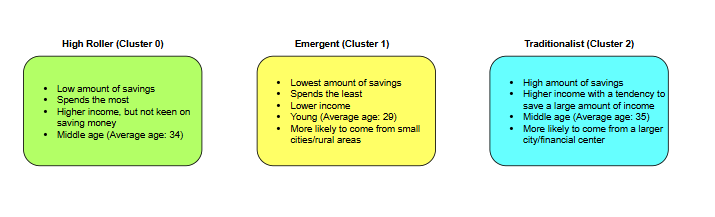

<a id='10.3'></a>
### 10.3 Cluster Specific Marketing Strategies

The assumption is that for the various recommendations I have provided, that the bank has not implemented any of them. Because the bank is not specified, it is not possible to research whether these recommendations have actually been implemented in real life.

**Important Note:** As a disclaimer, given that there are not very many features in this dataset (eg. we lack information about the customer's income), some of these recommendations are based on high level assumptions. Thus, if there were more features that provide more granular information on the customer, these recommendations will likely be different.

**Cluster 0** <br>

1. Increasing daily deposit, withdrawal and POS transaction limits may be advisable as this cluster transacts and thus spends the most.<br> source: https://www.investopedia.com/articles/managing-wealth/050716/10-checking-accounts-ultra-rich-use.asp <br>
2. As this cluster tends to spend the most, gold/platinum credit cards may be attractive to this segment. Platinum credit cards have higher credit limits and have more attractive rewards that can be appealing to this group. Gold/platinum credit cards have rewards such as higher cashback rates.<br>source: https://www.analyticsvidhya.com/blog/2021/03/customer-profiling-and-segmentation-an-analytical-approach-to-business-strategy-in-retail-banking/<br>
3. Given that the average age is 34 for this group, this group is likely to be starting families and planning for retirement. Thus, RESP savings accounts, pension plans, life and/or health insurance can be marketed to this group.<br>source: https://www.analyticsvidhya.com/blog/2021/03/customer-profiling-and-segmentation-an-analytical-approach-to-business-strategy-in-retail-banking/<br>
4. Because this segment typically spends a lot of money, this group may be receptive of loans, specifically secured personal loans as it typically carries a lower rate of interest.<br> source: https://www.creditkarma.com/personal-loans/i/types-of-loans <br><br>

**Cluster 1**<br>




1. This group may be underutilizing banking services, given the younger average age and lower incomes. Providing knowledge of basic banking products and services by issuing informational pamphlets and opportunities to consult with financial advisors will empower this group to fully utilize the bank's services.<br>source: https://www.abacademies.org/articles/the-use-of-banking-products-and-services-by-lowincome-and-underbanked-consumers-in-the-nelson-mandela-bay-8119.html <br>
2. Banking products and services marketed should be affordable and cost effective, such as checking accounts with low minimum account balances and debit accounts that do not require a minimum balance.<br>source 1: https://www.ublocal.com/guide-managing-bank-account/ <br>source 2: https://loanscanada.ca/money/is-your-bank-preying-on-you/ <br>
3. Because lower income individuals tend to be less likely to have a credit history, credit cards for low income individuals could have details such as a very low or even no income requirement, no annual fees, etc.<br>source: https://www.ratehub.ca/blog/the-6-best-credit-cards-for-low-income-in-canada-2021/ <br>
4. As this segment has the youngest average age, this group is more likely to be tech savvy. Digital banking products and services, such as mobile apps that enable automatic payments and online monitoring of records, may be a good sell.<br>source 1: https://theasiadialogue.com/2018/10/18/designing-better-financial-products-for-low-income-populations/ <br>source 2: https://tavaga.com/blog/digital-banking-and-its-foray-into-the-banking-sector/ <br>

**Cluster 2** <br>

1. Given that this segment has a propensity to save money, offering them higher interest products will be a likely sell. These could include fixed deposits, mutual funds, TFSA savings accounts, etc.<br>source: https://www.analyticsvidhya.com/blog/2021/03/customer-profiling-and-segmentation-an-analytical-approach-to-business-strategy-in-retail-banking/<br>
2. Provide tailored wealth management financial services. This group is more likely to invest with their large savings and will likely require advice from wealth professionals on how they can best invest and save their money.<br>source: https://www.insiderintelligence.com/insights/what-high-net-worth-investors-want-from-wealth-managers/<br>
3. The average age is 35 for this group, thus this group is likely to be starting families and planning for retirement. Thus, RESP savings accounts, pension plans, life and/or health insurance can be marketed to this group.<br>source: https://www.analyticsvidhya.com/blog/2021/03/customer-profiling-and-segmentation-an-analytical-approach-to-business-strategy-in-retail-banking/<br>
4. Given that this group is more likely to be starting families, buying houses, and investing, targeting this group with real estate investment options will be a likely sell.<br> source: https://www.ashianahousing.com/real-estate-blog/5-reasons-why-real-estate-is-your-safest-best-long-term-investment-option/ <br> 
5. With the age demographics of this age group, recommending car/home loans is viable as they will likely be buying or considering purchasing a car or a home.

<a id='10.4'></a>
### 10.4 Customer Acquisition Strategies

Cluster 2 customers are very important to the bank's operations as the bank needs the customers' deposits to lend to their borrowers and collect interest. <br><br>
1. North and West India have the highest relative proportion of customers in cluster 2. However, it is not only North and West India that have high GDP per capita. South India also has various states that have high GDP per capita. However, the distribution of customers by segment suggest otherwise, as South India has the largest proportion of cluster 1 clients. This suggests that based on these findings, there is a major opportunity to recruit cluster 2 type clients from South India and customer acquisition efforts for these two segments should be focused on South India.<br> Source: https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_GDP_per_capita <br>
2. Acquiring customers from the major cities, specifically from major financial and IT hubs, such as Mumbai and Gurgaon respectively, will likely increase the proportion of cluster 2 clients. <br> Source: Wikipedia <br>
3. As cluster 2 customers tend to be 35 or above, attracting customers in this age group will be worthwhile.<br>